<a href="https://colab.research.google.com/github/KarimBouzid/IFC_impedance_sensor/blob/main/GEL4072_7072_Atelier_IA_dans_les_syst%C3%A8mes_biom%C3%A9dicaux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Counting microparticles passing in a microchannel**

By Karim Bouzid

Content & Objectives

0. Biomedical data logging (done in previous workshops)
1. Data loader (and EDA - Exploratory Data Analysis)
2. Segmentation
3. Labeling (classification)
4. Feature extraction
5. Train/test split
6. Training
7. Validation / testing

# Packages import & function definitions (run this section first)

In [1]:
!pip install snorkel==0.9.5
!pip install scikit-learn==0.21.3
!pip install scipy==1.7.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 7.2 MB/s 
     |████████████████████████████████| 3.8 MB 41.8 MB/s 
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 10.4 MB 40.7 MB/s 
     |████████████████████████████████| 6.7 MB 47.1 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556008 sha256=7c950121512352bddc7a2220ba0399ad33c95dbf85e0e101b17705d90a6097c3
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully un

In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import snorkel
from google.colab import drive
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.interpolate import interp1d
import scipy
from scipy import signal

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

In [3]:
def getMAV(x):
    '''
    Computes the Mean Absolute Value (MAV)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Mean Absolute Value as [float]
    '''
    MAV = np.mean(np.abs(x))
    return MAV

def getRMS(x):
    '''
    Computes the Root Mean Square value (RMS)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Root Mean Square value as [float]
    '''
    RMS = np.sqrt(np.mean(x**2))
    return RMS

def getVar(x):
    '''
    Computes the Variance of EMG (Var)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Variance of EMG as [float]
    '''
    N = np.size(x)
    Var = (1/(N-1))*np.sum(x**2)
    return Var

def getSTD(x):
    '''
    Computes the Standard Deviation (SD)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Standard Deviation as [float]
    '''
    N = np.size(x)
    xx = np.mean(x)
    SD = np.sqrt(1/(N-1)*np.sum((x-xx)**2))
    return SD

def getZC(x, threshold=0):
    '''
    Computes the Zero Crossing value (ZC)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Zero Crossing value as [float]
    '''
    N = np.size(x)
    ZC=0
    for i in range(N-1):
        if (x[i]*x[i+1] < 0) and (np.abs(x[i]-x[i+1]) >= threshold):
            ZC += 1
    return ZC

def getSSC(x, threshold=0):
    '''
    Computes the Slope Sign Change value (SSC)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Slope Sign Change value as [float]
    '''
    N = np.size(x)
    SSC = 0
    for i in range(1, N-1):
        if (((x[i] > x[i-1]) and (x[i] > x[i+1])) or ((x[i] < x[i-1]) and (x[i] < x[i+1]))) and ((np.abs(x[i]-x[i+1]) >= threshold) or (np.abs(x[i]-x[i-1]) >= threshold)):
            SSC += 1
    return SSC

def getFF(x):
    '''
    Computes the Form Factor (FF)
    :param x: EMG signal vector as [1-D numpy array]
    :return: Form Factor value as [float]
    '''
    FF = getRMS(x)/getMAV(x)
    return FF

def getDiff(x):
    '''
    Computes the derivative 
    :param x: EMG signal vector as [1-D numpy array]
    :return: Derivative value as [float]
    '''
    Diff = np.gradient(x)
    return Diff

def getPC(x,y):
    '''
    Computes the Pearson correlation between variables 
    :param x: EMG signal vector as [1-D numpy array]
    :param y: EMG signal vector as [1-D numpy array]
    :return: Correlation value value as [float]
    '''
    PC,_ = scipy.stats.pearsonr(x,y)
    return PC

def getSC(x,y):
    '''
    Computes the Spearman correlation between variables 
    :param x: EMG signal vector as [1-D numpy array]
    :param y: EMG signal vector as [1-D numpy array]
    :return: Correlation value value as [float]
    '''
    SC,_ = scipy.stats.spearmanr(x,y)
    return SC

def getCC(x,y):
    '''
    Computes the cross-correlation between variables 
    :param x: EMG signal vector as [1-D numpy array]
    :param y: EMG signal vector as [1-D numpy array]
    :return: Correlation value value as [float]
    '''
    correlation = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    return lag

from snorkel.labeling import labeling_function
@labeling_function()
def lf_high_magnitude1_RMS(x):
  if abs(getRMS(x[:,0]))>350:
    return 0
  else:
    return -1

@labeling_function()
def lf_high_magnitude2_RMS(x):
  if abs(getRMS(x[:,1]))>350:
    return 0
  else:
    return -1

@labeling_function()
def lf_similar_magnitude_RMS(x):
  if getMAV(x[:,1])>0.9*getRMS(x[:,0]) and getRMS(x[:,1])<1.1*getRMS(x[:,0]) and getRMS(x[:,0])>0.9*getRMS(x[:,1]) and getRMS(x[:,0])<1.1*getRMS(x[:,1]):
    return 2
  else:
    return -1

@labeling_function()
def lf_magnitude_correlation(x):
  if abs(getCC(x[0:,0],x[0:,1])) != 0 and abs(getCC(x[0:,0],x[0:,1])) < 20:
    return 2
  else:
    return -1

@labeling_function()
def lf_low_magnitude1_RMS(x):
  if getRMS(x[0:,0]) < 80:
    return 1
  else:
    return -1

@labeling_function()
def lf_low_magnitude2_RMS(x):
  if getRMS(x[0:,1]) < 80:
    return 1
  else:
    return -1

#Calculate the impedance value
def calculateImpedance_from_csv(filename, Rg):
  df = pandas.read_csv(filename)
  data = df.to_numpy()

  yImp1 = data[:,1];  yImp2 = data[:,2];
  impP1 = data[:,3];  impP2 = data[:,4];

  #data1 = preprocessing.RobustScaler().fit_transform(yImp1.reshape(-1,1))
  #data2 = preprocessing.RobustScaler().fit_transform(yImp2.reshape(-1,1))
  #data3 = preprocessing.RobustScaler().fit_transform(impP1.reshape(-1,1))
  #data4 = preprocessing.RobustScaler().fit_transform(impP2.reshape(-1,1))

  data1 = yImp1.reshape(-1,1)
  data2 = yImp2.reshape(-1,1)
  data3 = impP1.reshape(-1,1)
  data4 = impP2.reshape(-1,1)

  return data1, data2, data3, data4

#Seeks the CSV in folder "data" and segment it in windows
def segment_dataset(window_length=200, classes=None):
    files = os.listdir()
    fileNames = []
    dataset1 = np.ndarray((0, window_length, 4))
    labels = np.ndarray((0,window_length,1))
    for f in files:
        if f.endswith('.csv'):
            fileNames.append(f)

    for i in fileNames:
        metaData = i.split('.')
        metaData2 = metaData[0].split('-')
        try:
           int(metaData2[0])
        except:
          continue
        Imp1,Imp2,P1,P2 = calculateImpedance_from_csv(i, int(metaData2[0])*1000)
        len_data = len(Imp1)
        n_window = int(len_data/window_length)

        indexer = np.arange(window_length)[None, :] + int(1/2*window_length)*np.arange(2*n_window)[:, None]
        print(indexer)
        data_windows_Imp1 = Imp1[indexer[0:-1]]
        data_windows_P1 = P1[indexer[0:-1]]
        data_windows_Imp2 = Imp2[indexer[0:-1]]
        data_windows_P2 = P2[indexer[0:-1]]
        print('File: ', i, data_windows_Imp1.shape)

        dataset1 = np.vstack((dataset1,np.dstack((data_windows_Imp1, data_windows_Imp2, data_windows_P1, data_windows_P2))))
        labels = np.vstack((labels, 0*np.ones(data_windows_Imp1.shape)))

    labels = labels[0:, 0].astype(int)
    return dataset1, labels

#Segments the csv files based on the location of their peaks in folder "data"
def segment_peaks_dataset(window_length=201, classes=None):
    files = os.listdir()
    fileNames = []
    dataset1 = np.ndarray((0, window_length, 4))
    labels = np.ndarray((0, window_length,1))
    for f in files:
        if f.endswith('.csv'):
            fileNames.append(f)

    for i in fileNames:
        metaData = i.split('.')
        metaData2 = metaData[0].split('-')
        try:
           int(metaData2[0])
        except:
          continue
        Imp1,Imp2,P1,P2 = calculateImpedance_from_csv(i, int(metaData2[0])*1000)
        len_input = len(Imp1)

        Imp1 = Imp1.reshape(-1)
        Imp2 = Imp2.reshape(-1)
        locs1,_ = scipy.signal.find_peaks(Imp1-Imp2,height=[80,1000], prominence=[200,1000], distance=11)
        locs2,_ = scipy.signal.find_peaks(Imp2-Imp1,height=[80,1000], prominence=[200,1000], distance=11)

        if len(locs1)<len(locs2):
            smallLocs = locs1; bigLocs = locs2;
        else:
            smallLocs = locs2; bigLocs = locs1;

        bigLocsNew = np.ndarray((len(bigLocs)))
        for k in range(len(bigLocs)):
          idx = np.argmin(np.abs(bigLocs[k]-smallLocs))
          distance = np.min(np.abs(bigLocs[k]-smallLocs))
          if distance<20:
            bigLocsNew[k]=bigLocs[idx]
          else:
            bigLocsNew[k]=0
        bigLocsNew = bigLocsNew[bigLocsNew != 0]
        bigLocsNew = np.unique(bigLocsNew)

        smallLocsNew = np.ndarray((len(bigLocsNew)))
        for k in range(len(bigLocsNew)):
          idx = np.argmin(np.abs(smallLocs-bigLocsNew[k]))
          smallLocsNew[k]=smallLocs[idx]
        
        print(bigLocs.shape, bigLocsNew.shape, smallLocs.shape, smallLocsNew.shape)

        meanLocs = np.ndarray((len(smallLocsNew)))
        for k in range(len(smallLocsNew)):
            meanLocs[k] = int(min(len_input, max(0, (bigLocsNew[k]+smallLocsNew[k])/2 -(window_length-1)/2)))

        indexer = np.arange(window_length)[None, :] + meanLocs.astype(int)[:, None]
        data_windows_Imp1 = Imp1[indexer[0:-1]]
        data_windows_P1 = P1[indexer[0:-1]]
        data_windows_Imp2 = Imp2[indexer[0:-1]]
        data_windows_P2 = P2[indexer[0:-1]]
        print('File: ', i, data_windows_Imp1.shape)

        dataset1 = np.vstack((dataset1,np.dstack((data_windows_Imp1, data_windows_Imp2, data_windows_P1, data_windows_P2))))
        labels = np.vstack((labels, 0*np.ones(data_windows_P1.shape)))

    labels = labels[0:, 0].astype(int)
    return dataset1, labels, meanLocs





def features_dataset(data, MAV=True, RMS=True, Var=True, SD=True, ZC=True, SSC=True, FF=True, PC = True, SC = True, CC = True):
    
    dataset = np.ndarray((4*sum([MAV, RMS, Var, SD, ZC, SSC, FF, SC, PC, CC]),0))
    for d in data:
      features = np.ndarray((0,1))
      if MAV==True:
        features = np.vstack((features, getMAV(d[0:,0]), getMAV(d[0:,1]), getMAV(d[0:,2]), getMAV(d[0:,3])))
      if RMS==True:
        features = np.vstack((features, getRMS(d[0:,0]), getRMS(d[0:,1]), getRMS(d[0:,2]), getRMS(d[0:,3])))
      if Var==True:
        features = np.vstack((features, getVar(d[0:,0]), getVar(d[0:,1]), getVar(d[0:,2]), getVar(d[0:,3])))
      if SD==True:
        features = np.vstack((features, getSTD(d[0:,0]), getSTD(d[0:,1]), getSTD(d[0:,2]), getSTD(d[0:,3])))
      if ZC==True:
        features = np.vstack((features, getZC(d[0:,0], 0), getZC(d[0:,1], 0), getZC(d[0:,2], 0), getZC(d[0:,3], 0)))
      if SSC==True:
        features = np.vstack((features, getSSC(d[0:,0], 0), getSSC(d[0:,1],0), getSSC(d[0:,2], 0), getSSC(d[0:,3],0)))
      if FF==True:
        features = np.vstack((features, getFF(d[0:,0]), getFF(d[0:,1]), getFF(d[0:,2]), getFF(d[0:,3])))
      if PC==True:
        features = np.vstack((features, getPC(d[0:,0],d[0:,1]), getPC(d[0:,0],d[0:,1]), getPC(d[0:,2],d[0:,3]), getPC(d[0:,2],d[0:,3])))
      if SC==True:
        features = np.vstack((features, getSC(d[0:,0],d[0:,1]), getSC(d[0:,0],d[0:,1]), getSC(d[0:,2],d[0:,3]), getSC(d[0:,2],d[0:,3])))
      if CC==True:
        features = np.vstack((features, getCC(d[0:,0],d[0:,1]), getCC(d[0:,0],d[0:,1]), getCC(d[0:,2],d[0:,3]), getCC(d[0:,2],d[0:,3])))
      dataset = np.hstack((dataset, features))
    return dataset.transpose()

# Theory

In this exercise, we will build a dataset from the impedance magnitude and phase of IFC signals recorded by sending Polystyrene microbeads of sizes between 10 and 90um in a saline water solution at 22°C in a 180um wide PDMS channel with parallel electrodes on PCBs. 

The classification objectives are to separate the instants where the channel contains no liquid, only liquid, liquid and beads/particles, and when an air bubble is present in the channel. This means there will be 4 classes [0, 1, 2, 3]. 

The classes are defined as such: 
* -1: Unsure!
* 0: No liquid
* 1: Liquid
* 2: Liquid & particles
* 3: Bubbles (false particle)

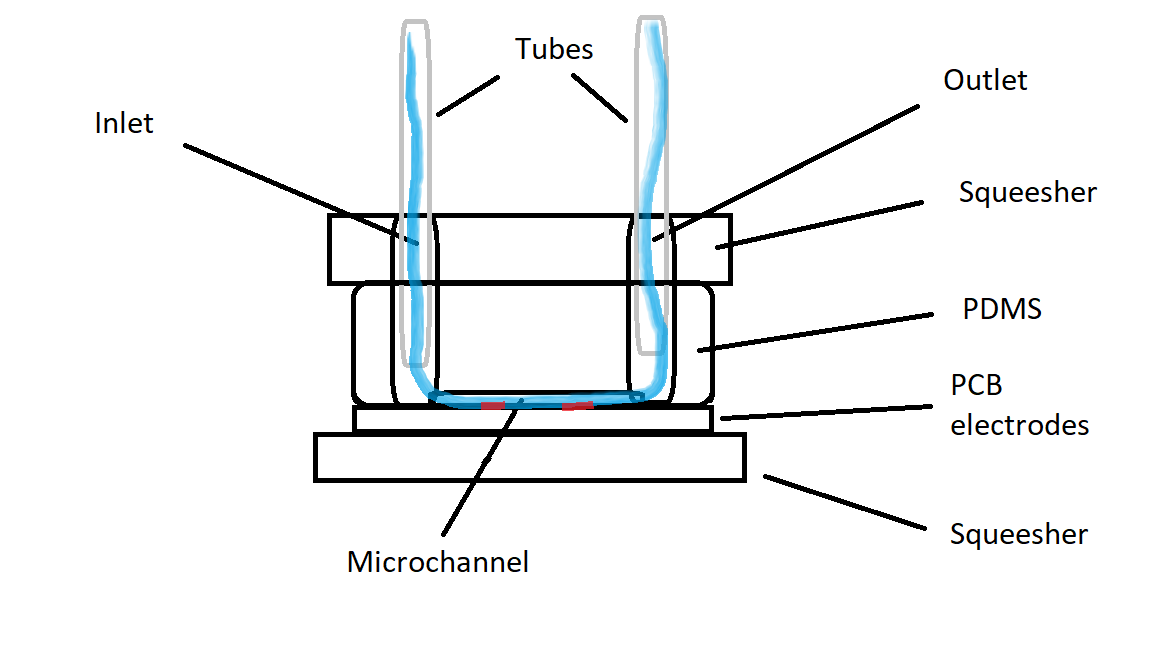

# Understanding the dataset

**1. Exploratory Data Analysis (EDA)**

Explore the data files, plot signals, etc.

Connect to Google Drive to access the dataset.

In [4]:
# Loading recorded EMG signals into numpy arrays
drive.mount('/content/drive')
os.chdir("drive/My Drive/data")

Mounted at /content/drive


Create and show the raw dataset for one of the IFC signals. 

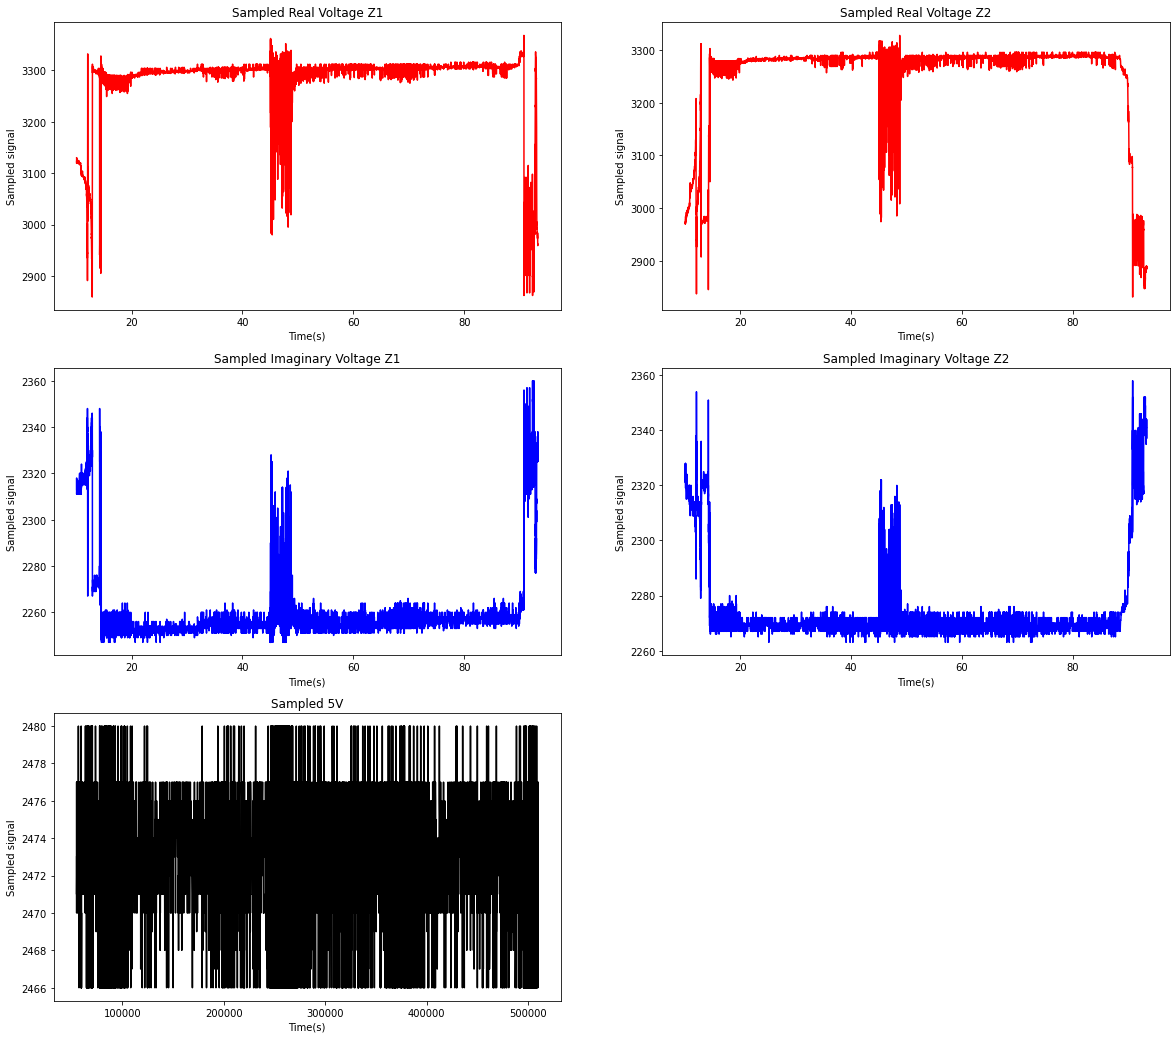

In [5]:
df = pandas.read_csv('Correlation7.csv')
data = df.to_numpy()
count = np.unwrap(data[0:,0],2000); sampled_r1 = data[0:,1]
sampled_r2 = data[0:,2]; sampled_ima1 = data[0:,3]
sampled_ima2 = data[0:,4]; sampled_5V = data[0:,5]

condition = (sampled_r1 >= 700) & (sampled_r1 <= 4000) & (sampled_r2 >= 700) & (sampled_r2 <= 4000) & (sampled_ima1 >= 700) & (sampled_ima1 <= 4000) & (sampled_ima2 >= 700) & (sampled_ima2 <= 4000) & (sampled_5V >= 1800) & (sampled_5V <= 4000)
sampled_r1 = sampled_r1[condition]
sampled_r2 = sampled_r2[condition]
sampled_ima1 = sampled_ima1[condition]
sampled_ima2 = sampled_ima2[condition]
sampled_5V = sampled_5V[condition]
count = count[condition]

condition = np.argsort(count)
count = count[condition]
sampled_r1 = sampled_r1[condition]
sampled_r2 = sampled_r2[condition]
sampled_ima1 = sampled_ima1[condition]
sampled_ima2 = sampled_ima2[condition]
sampled_5V = sampled_5V[condition]

t = count/5461.33;
plt.figure(figsize=(20, 18)); plt.subplot(3, 2, 1)
plt.title('Sampled Real Voltage Z1'); plt.xlabel('Time(s)');plt.ylabel('Sampled signal'); plt.plot(t, sampled_r1,'r')
plt.subplot(3, 2, 2); plt.title('Sampled Real Voltage Z2'); plt.xlabel('Time(s)'); plt.ylabel('Sampled signal'); plt.plot(t, sampled_r2,'r')
plt.subplot(3, 2, 3); plt.title('Sampled Imaginary Voltage Z1'); plt.xlabel('Time(s)'); plt.ylabel('Sampled signal'); plt.plot(t, sampled_ima1,'b')
plt.subplot(3, 2, 4); plt.title('Sampled Imaginary Voltage Z2'); plt.xlabel('Time(s)'); plt.ylabel('Sampled signal'); plt.plot(t, sampled_ima2,'b')
plt.subplot(3, 2, 5); plt.title('Sampled 5V'); plt.xlabel('Time(s)');plt.ylabel('Sampled signal'); plt.plot(count, sampled_5V,'k')
plt.show()


**2. Pre-processing**

Data processing to obtain an impedance magnitude and phase.

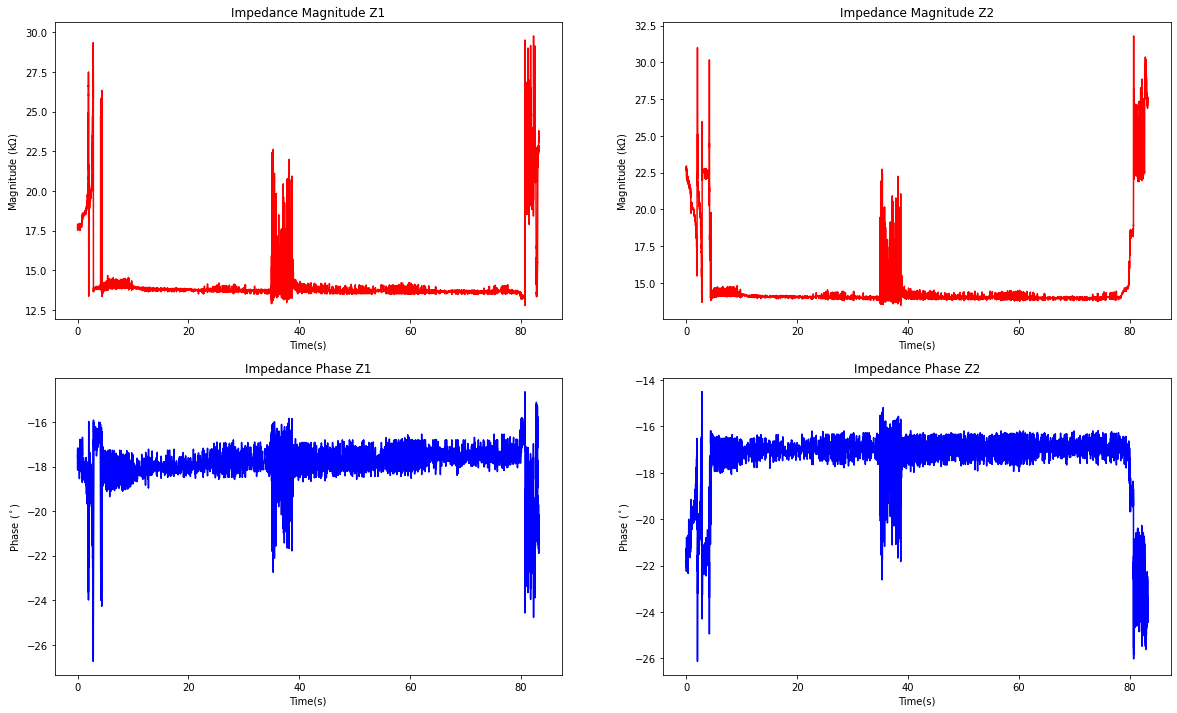

In [6]:
MeasGain = 1000/(1000+1000); Vdd = 1.943; SamplingRate = 5461;

V5 = sampled_5V*Vdd/4096*4.01
r1 = sampled_r1*Vdd/4096/MeasGain*(0.99) - V5/2;
r2 = sampled_r2*Vdd/4096/MeasGain*(0.991) - V5/2;
ima1 = sampled_ima1*Vdd/4096/MeasGain*(0.9875) - V5/2;
ima2 = sampled_ima2*Vdd/4096/MeasGain*(0.9884) - V5/2;

Rg = 47e3; Cg = 0.3e-12;
Gbuf = 1/8; Gain = 1; Vin=V5/1.28;

yImp1 = Rg*Vin*Gbuf*Gain/2./(np.sqrt((r1**2)+(ima1**2)));
impP1 = 180/np.pi*np.arctan2(ima1,r1);
yImp2 = Rg*Vin*Gbuf*Gain/2./(np.sqrt((r2**2)+(ima2**2)));
impP2 = 180/np.pi*np.arctan2(ima2,r2);

t = t-t[0];
plt.figure(figsize=(20, 12));
plt.subplot(2, 2, 1); plt.xlabel('Time(s)');plt.ylabel('Magnitude (k$\Omega$)'); plt.title('Impedance Magnitude Z1'); plt.plot(t, yImp1/1000,'r')
plt.subplot(2, 2, 2); plt.xlabel('Time(s)');plt.ylabel('Magnitude (k$\Omega$)'); plt.title('Impedance Magnitude Z2'); plt.plot(t, yImp2/1000,'r')
plt.subplot(2, 2, 3); plt.xlabel('Time(s)');plt.ylabel('Phase ($^\circ$)'); plt.title('Impedance Phase Z1'); plt.plot(t, impP1,'b')
plt.subplot(2, 2, 4); plt.xlabel('Time(s)');plt.ylabel('Phase ($^\circ$)'); plt.title('Impedance Phase Z2'); plt.plot(t, impP2,'b')
plt.show()

**3. Segmentation, feature extraction & labeling**

To generate a data point, segment the EMG signals in windows (window length depends on application). For each window:
* Calculate the chosen features
* Record the results in a feature vector (including features from both channels in one vector as shown below)
* Save the class label in a variable (the label is a numerical value associated with the type of particle). The classes are initialized at 0 since they are difficult to know. They will be processed on the next step. 

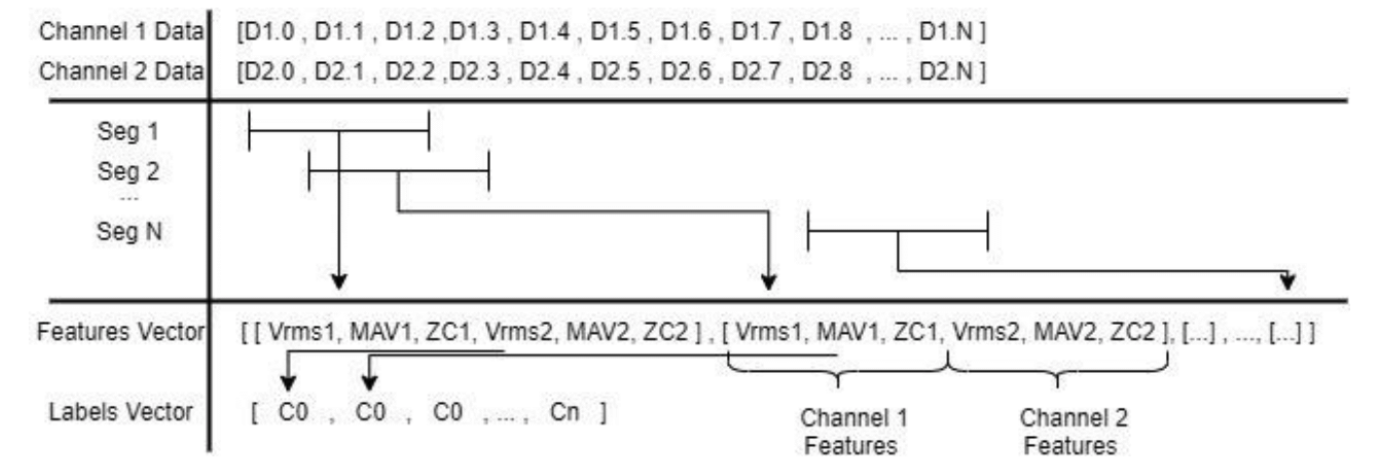

In [7]:
classes = [-1, 0, 1, 2]
wind_len = 51
#data1, labels = segment_dataset(wind_len,classes=classes)
data1, labels,Locs = segment_peaks_dataset(wind_len,classes=classes)
print('shape data: ',data1.shape)
print('shape labels: ',labels.shape)
print(labels)

(772,) (508,) (767,) (508,)
File:  47-PreprocessedNonSegmented8.csv (507, 51)
(531,) (346,) (521,) (346,)
File:  47-PreprocessedNonSegmented9.csv (345, 51)
(666,) (527,) (618,) (527,)
File:  47-PreprocessedNonSegmented6.csv (526, 51)
(695,) (477,) (662,) (477,)
File:  47-PreprocessedNonSegmented7.csv (476, 51)
(1142,) (857,) (1065,) (857,)
File:  47-PreprocessedNonSegmented4.csv (856, 51)
(1363,) (955,) (1314,) (955,)
File:  47-PreprocessedNonSegmented3.csv (954, 51)
(678,) (425,) (649,) (425,)
File:  47-PreprocessedNonSegmented5.csv (424, 51)
shape data:  (4088, 51, 4)
shape labels:  (4088, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


**4. Label extraction**

The data is hard to label so we will use Snorkel to find labels autmatically using predefined functions with weak-supervision. 

https://link.springer.com/article/10.1007/s00778-019-00552-1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data1, labels, test_size=0.33, random_state=42)
#Labeling functions
#LFs = [lf_high_magnitude, lf_low_magnitude_STD, lf_low_phase_STD,
       #lf_magnitude_SSC, lf_phase_SSC, lf_magnitude_FF]
LFs = [lf_high_magnitude1_RMS, lf_high_magnitude2_RMS, lf_similar_magnitude_RMS,
       lf_magnitude_correlation, lf_low_magnitude1_RMS, lf_low_magnitude2_RMS]

# Apply the LFs to the unlabeled training data
applier = snorkel.labeling.LFApplier(lfs=LFs)
L_full = applier.apply(data1)
L_train = applier.apply(X_train)
L_test = applier.apply(X_test)

from snorkel.labeling.model import LabelModel
# Train the label model and compute the training labels
label_model = LabelModel(cardinality=5, verbose=True)
label_model.fit(L_train, seed=12)
y_train = label_model.predict(L=L_train, tie_break_policy="abstain")

probs_full = label_model.predict(L=L_full,return_probs=False)

print(probs_full)
labels = probs_full
print('Unsure: ', np.count_nonzero(probs_full==-1), 'Bubbles: ', np.count_nonzero(probs_full==0), 'Liquid: ', np.count_nonzero(probs_full==1),'Beads: ', np.count_nonzero(probs_full==2))

snorkel.labeling.LFAnalysis(L=L_full, lfs=LFs).lf_summary()

4088it [00:00, 5300.40it/s]
2738it [00:00, 4941.07it/s]
1350it [00:00, 5006.66it/s]


[0 0 0 ... 0 0 0]
Unsure:  237 Bubbles:  1130 Liquid:  483 Beads:  2238


,j,Polarity,Coverage,Overlaps,Conflicts
lf_high_magnitude1_RMS,0,[0],0.223337,0.206703,0.135519
lf_high_magnitude2_RMS,1,[0],0.218444,0.210127,0.138943
lf_similar_magnitude_RMS,2,[2],0.063601,0.059442,0.038894
lf_magnitude_correlation,3,[2],0.797211,0.250489,0.229941
lf_low_magnitude1_RMS,4,[1],0.082681,0.074364,0.068982
lf_low_magnitude2_RMS,5,[1],0.074609,0.069961,0.064579


**5. Data splitting and training**

The feature vectors set
will be used as training data set and test data set. To shuffle the dataset, we will be using the
Kfold from the Scikit-learn package. This function will select arbitrary
indices in the dataset. These indices will be used to separate the feature vectors list and the labels list
in a train data set and
a test data set. This process will be done 3 times to get a mean
score/accuracy. This technique is used when the available dataset is relatively small to obtain a metric that is less biased
towards a limited dataset.

We will define a LDA classifier with the object
LinearDiscriminantAnalysis
() from the
Scikit
-
learn
python machine learning library
. Below, the object is instantiated in the variable
clf. The training process is
done with the function
fit
where the algorithm learns the discriminating functions from the features and labels
of the training data set. The performance of the training is evaluated with the function
score
where it predicts the labels
of the input d
ata and compares it to its true labels. A function
predict
exists to return the predicted labels
directly.

MAV:  351.40948277929004 112.48987728242486 0.20882616440086493 0.10969253829281289
RMS:  357.97441456643776 167.07400881855162 0.24922806446076715 0.14244489019275128
Var:  130708.59511386753 28471.998911155497 0.06335692067715751 0.020696357676865472
SD:  68.92168044175332 150.47380118299395 0.14953379325165905 0.1326851167255549
FF:  1.0186817149475473 1.4852359417113068 1.193471446338239 1.2985832255290635
PC:  -0.32669050200587696 0.7199645264013405
SC:  -0.13692307692307693 0.5950226244343891
CC:  2 0


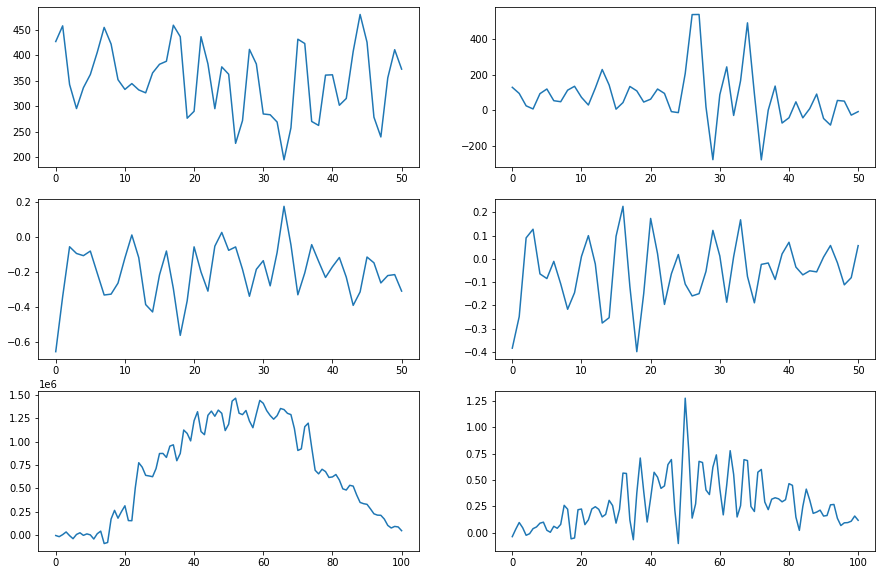

In [9]:
idx = 80

print('MAV: ', getMAV(data1[idx, 0:, 0]),getMAV(data1[idx, 0:, 1]), getMAV(data1[idx, 0:, 2]),getMAV(data1[idx, 0:, 3]))
print('RMS: ', getRMS(data1[idx, 0:, 0]),getRMS(data1[idx, 0:, 1]), getRMS(data1[idx, 0:, 2]),getRMS(data1[idx, 0:, 3]))
print('Var: ', getVar(data1[idx, 0:, 0]),getVar(data1[idx, 0:, 1]), getVar(data1[idx, 0:, 2]),getVar(data1[idx, 0:, 3]))
print('SD: ', getSTD(data1[idx, 0:, 0]),getSTD(data1[idx, 0:, 1]), getSTD(data1[idx, 0:, 2]),getSTD(data1[idx, 0:, 3]))
print('FF: ', getFF(data1[idx, 0:, 0]),getFF(data1[idx, 0:, 1]), getFF(data1[idx, 0:, 2]),getFF(data1[idx, 0:, 3]))
print('PC: ', getPC(data1[idx, 0:, 0],data1[idx, 0:, 1]), getPC(data1[idx, 0:, 2],data1[idx, 0:, 3]))
print('SC: ', getSC(data1[idx, 0:, 0],data1[idx, 0:, 1]), getSC(data1[idx, 0:, 2],data1[idx, 0:, 3]))
print('CC: ', getCC(data1[idx, 0:, 0],data1[idx, 0:, 1]), getCC(data1[idx, 0:, 2],data1[idx, 0:, 3]))

plt.figure(figsize=(15, 10)); #data1[6999], data1[3300], data[21000]
plt.subplot(3, 2, 1);
plt.plot(data1[idx, 0:, 0])
plt.subplot(3, 2, 2); 
plt.plot(data1[idx, 0:, 1])
plt.subplot(3, 2, 3);
plt.plot(data1[idx, 0:, 2])
plt.subplot(3, 2, 4); 
plt.plot(data1[idx, 0:, 3])
plt.subplot(3, 2, 5);
plt.plot(signal.correlate(data1[idx, 0:, 0], data1[idx, 0:, 1], mode="full"))
plt.subplot(3, 2, 6); 
plt.plot(signal.correlate(data1[idx, 0:, 2], data1[idx, 0:, 3], mode="full"))
plt.show()


In [10]:
features_set = features_dataset(data1,ZC=False, SSC=False,)
print(features_set.shape)


(4088, 32)


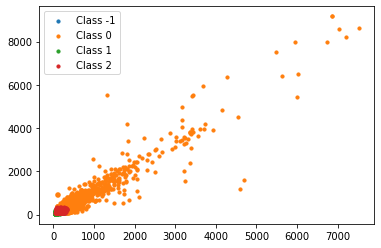

In [11]:
feat_x = 0  # 0-1-2-3: MAV, 4-5-6-7: RMS, 8-9-10-11: Var, 12-13-14-15: SD, 16-17-18-19: ZC, 10-11: SSC, 12-13: FF, 14-15: Diff,
feat_y = 1

for c in classes:
  ind = np.where(np.array(probs_full)==c)
  plt.scatter([f[feat_x] for f in features_set[ind]], [f[feat_y] for f in features_set[ind]], label='Class '+str(c), s=10)
plt.legend()
plt.show()

**CNN 1d**

Still mostly experimental

# Functions definition


In [12]:
# %% Definitions
import time
import math
import numpy
import pandas

from matplotlib import pyplot

from random import sample  

import os
os.environ["OMP_NUM_THREADS"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold, train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler

from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torchvision.transforms as T

# %% Réseaux à convolution

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes         
        for item in images:  
            count[item] += 1    
        weight_per_class = [0.] * n_classes                                      
        N = np.float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/np.float(count[i])                                 
        weight = [0] * len(images) 
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[val]    
        return weight

    n_classes = numpy.unique(dataset.y_train)
    weights = make_weights_for_balanced_classes(dataset.y_train, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        targets = targets.type(torch.FloatTensor).unsqueeze(-1)
        images = images.type(torch.FloatTensor).unsqueeze(-1)
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
        print(predictions_numpy)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

def compute_confusion_matrix(model, dataloader, device):
    # Mettre le model en mode évaluation
    model.eval()

    # Calculer toutes les prédictions sur le dataloader
    all_predictions = []
    all_targets = []
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        targets = targets.type(torch.FloatTensor).unsqueeze(-1)
        images = images.type(torch.FloatTensor).unsqueeze(-1)
        #print(images.shape)
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    predictions_numpy = numpy.concatenate(all_predictions)
    targets_numpy = numpy.concatenate(all_targets)

    T00, T11, T22, F01, F10, F02, F20, F12, F21 = 0,0,0,0,0,0,0,0,0
    for pred,targ in zip(predictions_numpy,targets_numpy):
        if targ == pred:
          if targ==0:
            T00 += 1
          elif targ==1:
            T11 += 1
          else:
            T22 += 1
        else:
          if targ == 0:
            if pred == 1:
              F01 += 1
            elif pred == 2:
              F02 += 1
          elif targ == 1:
            if pred == 0:
              F10 += 1
            elif pred == 2:
              F12 += 1
          elif targ == 2:
            if pred == 0:
              F20 += 1
            elif pred == 2:
              F21 += 1

    matrix = numpy.array([[T00, F01, F02],[F10, T11, F12], [F20, F21, T22]])

    return matrix


class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=wind_len, out_channels=128, kernel_size=(2,1), stride=(1,1))
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(5,1), stride=(1,5))
        self.layer2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)
        self.layer2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1)
        self.layer3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)
        self.layer4 = nn.Flatten()
        self.out_layer = nn.Linear(in_features=32, out_features=1)
        self.mas = nn.Dropout(0.5)
        
    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        x = self.act1(x)
        #print(x.shape)
        x = self.layer2(x)
        x = self.act1(x)
        #print(x.shape)
        x = self.layer3(x)
        x = self.act1(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = self.out_layer(x)
        #print(x.shape)
        #print(min(x), max(x), np.mean(x.detach().numpy()))
        out = torch.sigmoid(x)
        return out


class FeatureDataset(Dataset):
    """
    Cette classe sert à définir le dataset IFC réalisé 
    par Karim Bouzid lors de sa maîtrise à l'ULAVAL

    Args:
        dataset (3d ndarray): data to be analyzed
        labels (1d ndarray): class of the dataset
    """

    def __init__(self, dataset, labels):
        super().__init__()
        x = dataset[0:,0:,0:2]
        y = labels
        
        self.X_train = torch.tensor(x, dtype = torch.float32)
        self.y_train = torch.tensor(y)
        

    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]

    def __len__(self):
        return len(self.y_train)

    def get_beads(self, index):
        idx = np.where(self.y_train==2)
        idx = idx[0]
        print(idx[index], getMAV(X_train[idx[index],0:,0]), getRMS(X_train[idx[index],0:,0]), getVar(X_train[idx[index],0:,0]), getSTD(X_train[idx[index],0:,0]), getFF(X_train[idx[index],0:,0]))
        return self.X_train[idx[index]].numpy(), self.y_train[idx[index]].numpy()

cpu


# Evaluate the CNN

8 427.8621003065231 475.27140479327596 230400.56637845747 219.06092131588733 1.1108051039173337
9 63.691325300746456 88.9792331490087 8075.650010421364 89.80985627987302 1.3970384935288178
12 300.1617906983102 337.68244647756427 116310.02335225453 184.13895037712268 1.1250014390304786
13 71.78380698656784 99.46006793516449 10090.151215940887 100.18359988521773 1.385550197327587


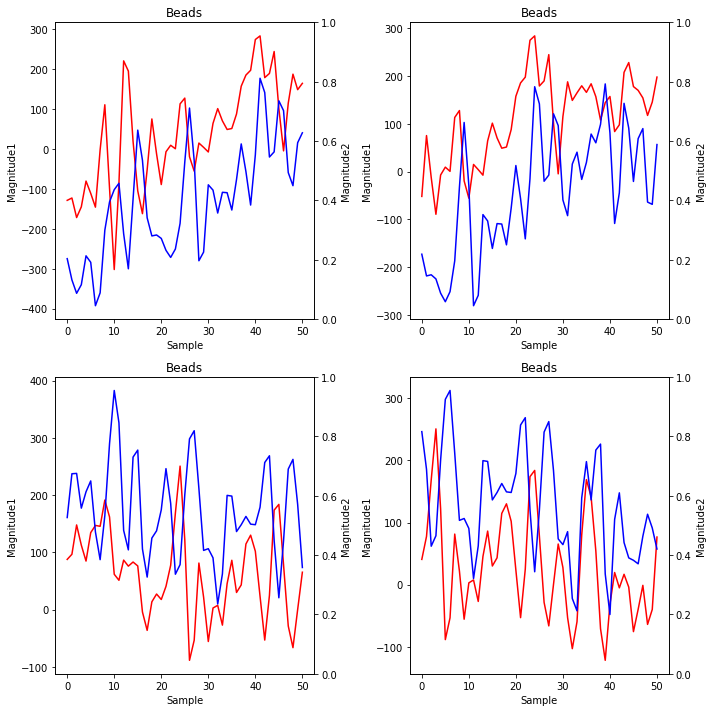

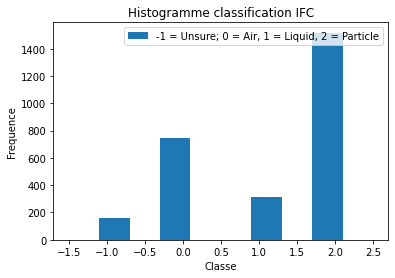

In [13]:
# Creation du dataset
X_train, X_test, y_train, y_test = train_test_split(data1, labels, test_size=0.33, random_state=42)
data_set = FeatureDataset(data1, labels)

idx = 0
fig, subfigs = pyplot.subplots(2, 2, tight_layout=True)
fig.set_figwidth(10)
fig.set_figheight(10)
for subfig in subfigs.reshape(-1):
    # Affichage des images aléatoires
    data, lab = data_set.get_beads(idx)
    subfig.plot(data[0:,0],'r')
    subfig.set_xlabel("Sample")
    subfig.set_ylabel("Magnitude1")
    subfig2=subfig.twinx()
    subfig.plot(data[0:,1],'b')
    subfig2.set_ylabel("Magnitude2")
    idx += 1

    if lab == 2:
      subfig.set_title("Beads")
    elif lab == 1:
      subfig.set_title("Liquid")
    elif lab == 0:
      subfig.set_title("Bubbles")
    else:
      subfig.set_title("Unsure")

fig, subfig = pyplot.subplots()
# Visualisation de la distribution des données dans le train_set
subfig.hist(y_train,10,range=(-1.5,2.5))
subfig.legend(["-1 = Unsure; 0 = Air, 1 = Liquid, 2 = Particle"])
subfig.set_title("Histogramme classification IFC")
subfig.set_xlabel("Classe"); subfig.set_ylabel("Frequence");

In [14]:
# %% V1 CNN 1d
nb_epoch = 10
learning_rate = 0.1
momentum = 0.9
batch_size = 20

data_set_test = FeatureDataset(X_test,y_test)

# Création du sampler avec les classes balancées
balanced_train_sampler = create_balanced_sampler(data_set)
balanced_test_sampler = create_balanced_sampler(data_set_test)

# Création du dataloader d'entraînement
train_loader = DataLoader(data_set, batch_size=batch_size, sampler=balanced_train_sampler)
test_loader = DataLoader(data_set_test, batch_size=batch_size, sampler=balanced_test_sampler)

model = Simple1DCNN().float()

model.to(DEVICE)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)

model.train()

for i_epoch in range(nb_epoch):

    start_time, train_losses = time.time(), []
    for i_batch, batch in enumerate(train_loader):
        images, targets = batch
        targets = targets.type(torch.FloatTensor).unsqueeze(-1)
        images = images.type(torch.FloatTensor).unsqueeze(-1)

        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        
        # Mettre les gradients à zéro
        optimizer.zero_grad()

        # Calculer:
        # 1. l'inférence dans une variable "predictions"
        # 2. l'erreur dans une variable "loss"
        predictions = model(images)
        #print(predictions)
        loss = criterion(predictions, targets)

        # Rétropropager l'erreur et effectuer
        # une étape d'optimisation
        loss.backward()
        optimizer.step()

        # Accumulation du loss de la batch
        train_losses.append(loss.item())

    print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
        i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

# Affichage du score en test
test_acc = compute_accuracy(model, test_loader, DEVICE)
print(' [-] test acc. {:.6f}%'.format(test_acc * 100))

# Affichage de la matrice de confusion
matrix = compute_confusion_matrix(model, test_loader, DEVICE)
print(matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 [-] epoch    1/10, train loss 49.292170 in 0.46s
 [-] epoch    2/10, train loss 49.524390 in 0.40s
 [-] epoch    3/10, train loss 49.073171 in 0.36s
 [-] epoch    4/10, train loss 49.975610 in 0.39s
 [-] epoch    5/10, train loss 49.390244 in 0.50s
 [-] epoch    6/10, train loss 51.170732 in 0.44s
 [-] epoch    7/10, train loss 47.182927 in 0.48s
 [-] epoch    8/10, train loss 48.743902 in 0.49s
 [-] epoch    9/10, train loss 50.707317 in 0.43s
 [-] epoch   10/10, train loss 48.682927 in 0.43s
[0. 0. 0. ... 0. 0. 0.]
 [-] test acc. 23.185185%
[[340   0   0]
 [309   0   0]
 [353   0   0]]


Now that the accurate labels are found. We can characterize the beads properties in a scatterplot. 

(2238, 51, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PeakPropertyWarning: some peaks have a prominence of 0
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PeakPropertyWarning: some peaks have a width of 0
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PeakPropertyWarning: some peaks have a prominence of 0
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PeakPropertyWarning: some peaks have a prominence of 0
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PeakPropertyWarning: some peaks have a width of 0
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PeakPropertyWarning: some peaks have a prominence of 0


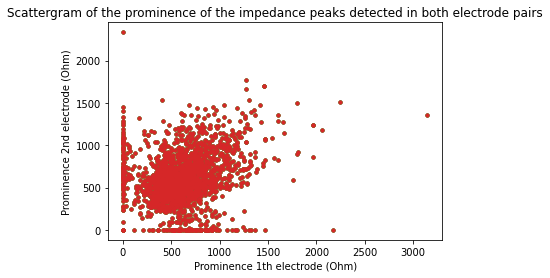

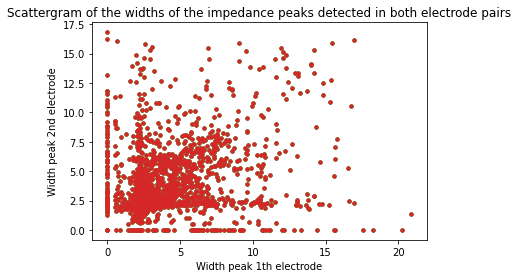

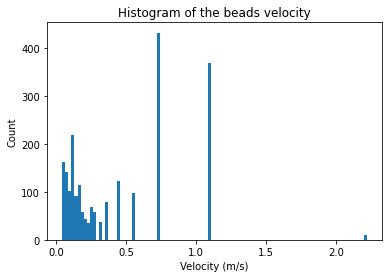

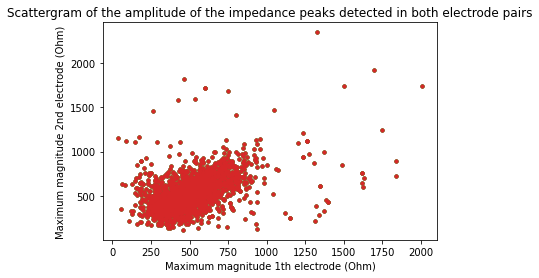

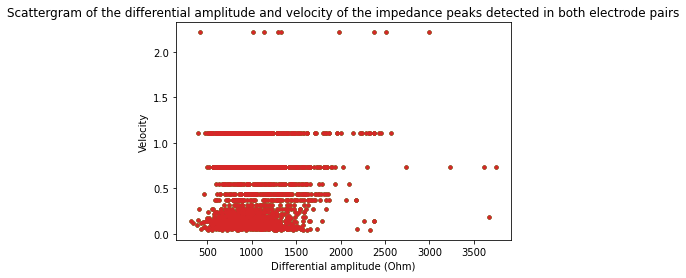

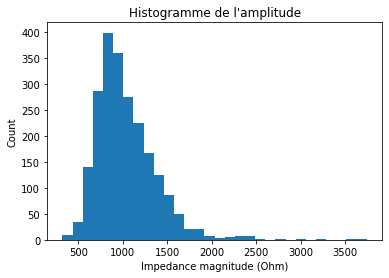

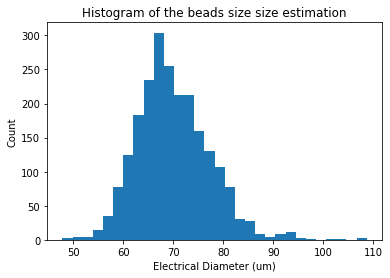

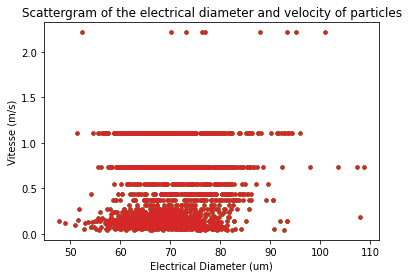

In [18]:
data_beads = data1[labels==2]
print(data_beads.shape)

prom1 = []
widths1 = []
prom2 = []
widths2 = []
amp1 = []
amp2 = []
distance = []
for k in range(len(data_beads)):
  locs1 =list([np.argmax(data_beads[k,:,0]-data_beads[k,:,1])])
  widths1.append(float(scipy.signal.peak_widths(data_beads[k,:,0]-data_beads[k,:,1], locs1, rel_height=0.5)[0]))
  prom1.append(float(scipy.signal.peak_prominences(data_beads[k,:,0]-data_beads[k,:,1], locs1)[0]))
  locs2 =list([np.argmax(data_beads[k,:,1]-data_beads[k,:,0])])
  widths2.append(float(scipy.signal.peak_widths(data_beads[k,:,1]-data_beads[k,:,0], locs2, rel_height=0.5)[0]))
  prom2.append(float(scipy.signal.peak_prominences(data_beads[k,:,1]-data_beads[k,:,0], locs2)[0]))
  amp1.append((data_beads[k,locs1,0]-np.min(data_beads[k,:,0])))
  amp2.append((data_beads[k,locs2,1]-np.min(data_beads[k,:,1])))
  distance.append(np.abs(locs1[0]-locs2[0]))

widths1 = np.array(widths1)
widths2 = np.array(widths2)
prom1 = np.array(prom1)
prom2 = np.array(prom2)
amp1 = np.array(amp1)
amp2 = np.array(amp2)
distance = np.array(distance)
#condition = (prom1<2000) & (prom2<2000) & (prom1>0) & (prom2>0)
#prom1 = prom1[condition]; prom2 = prom2[condition]; widths1 = widths1[condition]; widths2 = widths2[condition]

plt.figure()
for c in classes:
  plt.scatter([f for f in prom1], [f for f in prom2], s=10)
plt.title("Scattergram of the prominence of the impedance peaks detected in both electrode pairs")
plt.xlabel("Prominence 1th electrode (Ohm)"); plt.ylabel("Prominence 2nd electrode (Ohm)");
plt.show()

plt.figure()
for c in classes:
  plt.scatter([f for f in widths1], [f for f in widths2], s=10)
plt.title("Scattergram of the widths of the impedance peaks detected in both electrode pairs")
plt.xlabel("Width peak 1th electrode"); plt.ylabel("Width peak 2nd electrode");
plt.show()

fig, subfig = pyplot.subplots()
# Visualisation de la distribution des données dans le train_set
L = 0.406/1000;
subfig.hist(L/(distance/5461),100)
subfig.set_title("Histogram of the beads velocity")
subfig.set_xlabel("Velocity (m/s)"); subfig.set_ylabel("Count");

plt.figure()
for c in classes:
  plt.scatter([f for f in amp1], [f for f in amp2], s=10)
plt.title("Scattergram of the amplitude of the impedance peaks detected in both electrode pairs")
plt.xlabel("Maximum magnitude 1th electrode (Ohm)"); plt.ylabel("Maximum magnitude 2nd electrode (Ohm)");
plt.show()

plt.figure()
for c in classes:
  plt.scatter([f for f in amp1+amp2], [f for f in L/(distance/5461)], s=10)
plt.title("Scattergram of the differential amplitude and velocity of the impedance peaks detected in both electrode pairs")
plt.xlabel("Differential amplitude (Ohm)"); plt.ylabel("Velocity");
plt.show()

fig, subfig = pyplot.subplots()
# Visualisation de la distribution des données dans le train_set
subfig.hist(amp1+amp2,30)
subfig.set_title("Histogramme de l'amplitude")
subfig.set_xlabel("Impedance magnitude (Ohm)"); subfig.set_ylabel("Count");

fig, subfig = pyplot.subplots()
# Visualisation de la distribution des données dans le train_set
subfig.hist(7*np.power((amp1+amp2),(1/3)),30)
subfig.set_title("Histogram of the beads size size estimation")
subfig.set_xlabel("Electrical Diameter (um)"); subfig.set_ylabel("Count");

plt.figure()
for c in classes:
  plt.scatter([f for f in 7*np.power((amp1+amp2),(1/3))
], [f for f in L/(distance/5461)], s=10)
plt.title("Scattergram of the electrical diameter and velocity of particles")
plt.xlabel("Electrical Diameter (um)"); plt.ylabel("Vitesse (m/s)");
plt.show()
